# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.001181,True,6.803203
1,1.578884,True,11.466826
2,-0.345001,False,-1.243146
3,-1.660052,True,-0.526224
4,0.591192,False,0.993845
...,...,...,...
995,-0.069820,True,2.770006
996,0.431811,True,6.883272
997,-1.277517,True,1.212094
998,-2.215399,True,-2.423150


<AxesSubplot:xlabel='v0'>

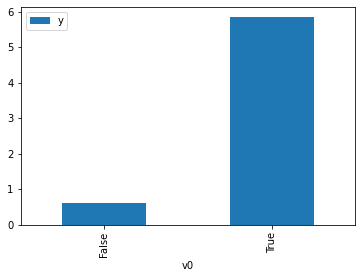

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

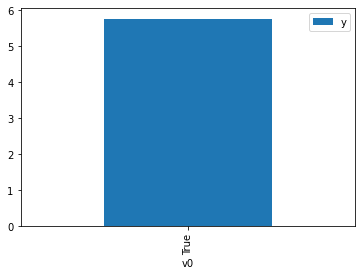

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.513085,False,-3.857261,0.541607,1.846356
1,-1.529737,False,-3.684627,0.542003,1.845007
2,1.145438,False,3.636374,0.478034,2.091900
3,0.058904,False,0.255471,0.504047,1.983940
4,0.439149,False,1.718435,0.494939,2.020451
...,...,...,...,...,...
995,-0.500210,False,-2.749405,0.517434,1.932615
996,-0.772166,False,-2.993691,0.523937,1.908626
997,0.534231,False,1.355369,0.492662,2.029790
998,0.556730,False,1.238860,0.492123,2.032012


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.243258,True,4.898784,0.488716,2.046177
1,0.832950,True,7.403233,0.514490,1.943671
2,0.663686,True,6.832241,0.510438,1.959101
3,0.778061,True,9.368043,0.513176,1.948647
4,-0.283242,True,3.938525,0.487759,2.050193
...,...,...,...,...,...
995,-0.519643,True,3.521721,0.482101,2.074253
996,1.628627,True,11.150675,0.533504,1.874400
997,1.592212,True,9.630996,0.532636,1.877456
998,1.285854,True,7.551198,0.525322,1.903595


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.205e+04
Date:                Tue, 16 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:16:45   Log-Likelihood:                         -1437.7
No. Observations:                1000   AIC:                                      2879.
Df Residuals:                     998   BIC:                                      2889.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8905      0.034     86.228      0.000       2.825       2.956
x2             4.9777      0.047    106.449      0.000       4.886       5.069
==============================================================================
Omnibus:                        3.251   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.087
Skew:                          -0.088   Prob(JB):                        0.214
Kurtosis:                       2.793   Cond. No.                         1.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""